## Map Object Data to Pickles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree


In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Your current machine name is iMac-de-Sylvie.local. Check your python environment


In [4]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0


3630.7805477010033

## Initialisation

### Read the list of objects

In [5]:
#filename_data =  "list_of_isolatedobjects.csv" # 67 objects, produced by buggy **MultiColor_lightCurves-DMRehearsal2024_01-AuxTel.ipynb**
filename_data = "isolated_objects_magandcolors_psfap_good.csv" # Must use this file produced by **ColorIsolatedObjects.ipynb**

In [6]:
df_data = pd.read_csv(filename_data ,index_col=0)

In [7]:
df_data

,obj,ra_psf,dec_psf,g_psf,r_psf,i_psf,z_psf,y_psf,sg_psf,sr_psf,...,y_ap,sg_ap,sr_ap,si_ap,sz_ap,sy_ap,g_r_ap,z_y_ap,sig_g_r_ap,sig_z_y_ap
0,64.0,122.458941,-36.203410,15.777671,15.297370,15.071238,14.976903,14.992762,0.021693,0.020236,...,20.182860,0.056633,0.047571,0.021300,0.049328,0.039498,0.289859,-1.114092,0.073962,0.063193
1,97.0,122.443240,-36.188544,16.445282,15.197287,14.557551,14.212338,14.017652,0.025860,0.020512,...,19.279466,0.047150,0.081202,0.023012,0.050353,0.070916,1.049318,-0.972267,0.093898,0.086974
2,101.0,122.558802,-36.184123,14.703686,13.661007,13.141518,12.923124,12.840352,0.020974,0.018582,...,18.050986,0.055059,0.102213,0.018322,0.320493,0.089106,0.833303,-1.030041,0.116099,0.332650
3,108.0,122.476592,-36.168954,13.855750,13.133322,12.888260,12.780897,12.791457,0.024153,0.025324,...,18.080316,0.065904,0.060305,0.007775,0.056280,0.081759,0.532255,-1.203073,0.089331,0.099257
4,109.0,122.556549,-36.138404,15.638635,15.116135,14.870493,14.804029,14.853749,0.021991,0.034464,...,20.063009,0.066161,0.091611,0.017728,0.081975,0.057955,0.323861,-1.140820,0.113004,0.100393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,948.0,122.448884,-36.103365,15.072865,13.927704,NaN,13.083084,12.926657,0.013853,0.030046,...,18.187967,0.039368,0.037558,0.000000,0.026176,0.052686,0.961662,-1.024188,0.054410,0.058830
63,950.0,122.445400,-36.083626,15.110121,13.739307,NaN,12.679976,12.464089,0.018800,0.023283,...,17.706622,0.038939,0.026312,0.000000,0.022561,0.055744,1.206305,-0.959469,0.046995,0.060137
64,958.0,122.543695,-36.089885,14.395186,14.108853,NaN,13.970446,14.050535,0.029747,0.210734,...,19.283176,0.058415,0.049722,0.000000,0.026359,0.071106,0.107770,-1.236020,0.076711,0.075835
65,963.0,122.427313,-36.079753,15.752085,15.091510,NaN,14.460498,14.323321,0.026600,0.031053,...,19.568581,0.038676,0.021747,0.000000,0.022485,0.052165,0.463725,-1.028688,0.044371,0.056805


In [8]:
def ComputeErrors(row):
    """
    """
    s_GR = np.sqrt(row["smagG"]**2 + row["smagR"]**2)
    s_ZY = np.sqrt(row["smagZ"]**2 + row["smagY"]**2)
    s_ap_GR = np.sqrt(row["sapmagG"]**2 + row["sapmagR"]**2)
    s_ap_ZY = np.sqrt(row["sapmagZ"]**2 + row["sapmagY"]**2)
    return pd.Series(data = [s_GR,s_ZY,s_ap_GR,s_ap_ZY],index= ["s_GR","s_ZY","s_ap_GR","s_ap_ZY"])

In [9]:
if filename_data ==  "list_of_isolatedobjects.csv":
    df_data_err = df_data.apply(ComputeErrors,axis=1,result_type='expand')
    df_data_comb = df_data.join(df_data_err)
    df_data =   df_data_comb

In [10]:
list(df_data.columns)

['obj',
 'ra_psf',
 'dec_psf',
 'g_psf',
 'r_psf',
 'i_psf',
 'z_psf',
 'y_psf',
 'sg_psf',
 'sr_psf',
 'si_psf',
 'sz_psf',
 'sy_psf',
 'g_r_psf',
 'z_y_psf',
 'sig_g_r_psf',
 'sig_z_y_psf',
 'ra_ap',
 'dec_ap',
 'g_ap',
 'r_ap',
 'i_ap',
 'z_ap',
 'y_ap',
 'sg_ap',
 'sr_ap',
 'si_ap',
 'sz_ap',
 'sy_ap',
 'g_r_ap',
 'z_y_ap',
 'sig_g_r_ap',
 'sig_z_y_ap']

### Atmosphere

In [11]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.2


In [12]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


### My tool to process atmosphere

In [13]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [14]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [15]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [16]:
def ComputeColors(the_pc,the_sed1,the_sed2): 
    """
    parameters:
     the_pc : PhotometricCorrections object with multi-values PWV
     the_sed1 : the rubin_sim SED for object 1
     the_sed2 : another rubin_sim SED for object 2
     
    return:
     all_df_magcol : pandas dataframe with calculated colors G-R and Z-Y for the two objects 
    """
    all_df_magcol = []
    for index,pwv in enumerate(all_pwv):
        atm_bands = the_pc.coll_bandpass_total_nonstd[index]
        mags_pwv1 = {}
        mags_pwv2 = {}
        madus_pwv1 = {}
        madus_pwv2 = {}
        for f in filter_tagnames: 
            mags_pwv1[f] = the_sed1.calc_mag(atm_bands[f])
            mags_pwv2[f] = the_sed2.calc_mag(atm_bands[f])
            madus_pwv1[f] = -2.5*np.log10(the_sed1.calc_adu(atm_bands[f],photoparams))
            madus_pwv2[f] = -2.5*np.log10(the_sed2.calc_adu(atm_bands[f],photoparams))
        # AB colors for star 1
        mags_pwv1["g-r"] = mags_pwv1["g"]- mags_pwv1["r"]  
        mags_pwv1["z-y"] = mags_pwv1["z"]- mags_pwv1["y"] 
        # AB colors for star 2
        mags_pwv2["g-r"] = mags_pwv2["g"]- mags_pwv2["r"]  
        mags_pwv2["z-y"] = mags_pwv2["z"]- mags_pwv2["y"] 
        # ADU mag colors for star 1
        # MADU colors for star 1
        madus_pwv1["g-r"] = madus_pwv1["g"]- madus_pwv1["r"]  
        madus_pwv1["z-y"] = madus_pwv1["z"]- madus_pwv1["y"] 
        # MADU colors for star 2
        madus_pwv2["g-r"] = madus_pwv2["g"]- madus_pwv2["r"]  
        madus_pwv2["z-y"] = madus_pwv2["z"]- madus_pwv2["y"] 
        
        df1 = pd.DataFrame(mags_pwv1, index=["abmag_1"]).T
        df2 = pd.DataFrame(mags_pwv2, index=["abmag_2"]).T
        df3 = pd.DataFrame(madus_pwv1, index=["instmag_1"]).T
        df4 = pd.DataFrame(madus_pwv2, index=["instmag_2"]).T
        df = pd.concat([df1,df2,df3,df4],axis=1)
        all_df_magcol.append(df)
        
    return all_df_magcol

In [17]:
def ComputeRelativeDiffColor(the_all_df_magcol):
    """
    parameters:
    - the_all_df_magcol : pandas dataframe containing colors for the two SED objects
    return:
    
    """

    df_diffcol = pd.DataFrame(columns=["pwv","Czy1_Czy2_abmag","Czy1_Czy2_instmag"])
    for index,pwv in enumerate(all_pwv):
        the_df = the_all_df_magcol[index]
        DCzyabmag = the_df.loc["z-y","abmag_1"] - the_df.loc["z-y","abmag_2"]
        DCzyadumag = the_df.loc["z-y","instmag_1"] - the_df.loc["z-y","instmag_2"]
        df_diffcol.loc[index] = [pwv,DCzyabmag,DCzyadumag]

    # Relative difference color is in mmag for plotting
    df_diffcol["Czy1_Czy2_abmag_rel"] =  (df_diffcol["Czy1_Czy2_abmag"] - df_diffcol.loc[0,"Czy1_Czy2_abmag"])*1000
    df_diffcol["Czy1_Czy2_instmag_rel"] =  (df_diffcol["Czy1_Czy2_instmag"] - df_diffcol.loc[0,"Czy1_Czy2_instmag"])*1000

    # differentiation  mmag per mm
    dx = np.diff(df_diffcol.pwv.values).mean()
    dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
    dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    return df_diffcol

### rubinsimphot

In [18]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir


In [19]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

In [20]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/AtmosphericTransmission/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### SED pickles

In [21]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')
seddir = os.path.join(fdir, 'pysynphot', 'pickles')
seddir_uvk = os.path.join(seddir,"dat_uvk")
all_pickles_uvk = sorted(os.listdir(seddir_uvk))
file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")
hdul = fits.open(file_ref)
df_pickle = pd.DataFrame(hdul[1].data)

In [22]:
NSED = len(df_pickle)

In [23]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_8770/1564809273.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(labels,rotation=45);
/Users/dagoret/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


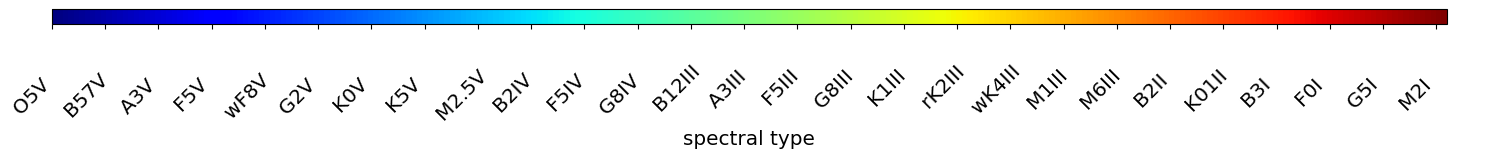

In [24]:
fig, ax = plt.subplots(figsize=(18, 0.2), layout='constrained')
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=NSED)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal', label='spectral type')

# change the number of labels
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
cbar.ax.locator_params(axis='x', nbins=4*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]

# rename the labels
Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_xticklabels(labels,rotation=45);
plt.show()



/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_8770/2539020644.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(labels,rotation=0);


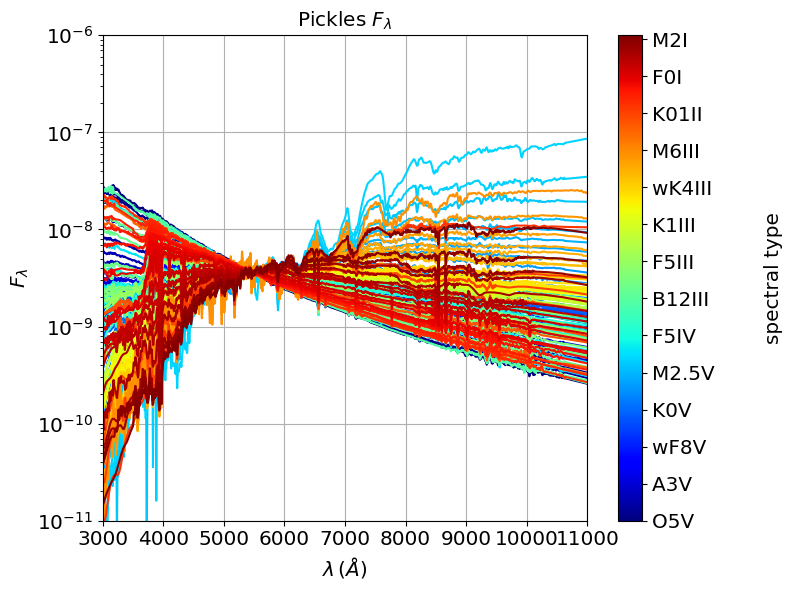

In [25]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    if index < 100 or index > 104: 
        ax.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
ax.set_yscale('log')
ax.set_xlim(3000.,11000)
ax.set_ylim(1e-11,1e-6)
ax.grid()
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")
#plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
#ax.collections[-1].colorbar

cbar =fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, orientation='vertical', label='spectral type')

#cbar = plt.colorbar(ax.collections[0],ax=ax)
#cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_yticklabels(labels,rotation=0);
plt.tight_layout()


#### Convert Pickles SED in ubin_sim Photmat

In [26]:
all_sed = []
all_sed_type = []
all_sed_filename = []
zmag = 20.0
for index in np.arange(NSED):
    if index < 100 or index > 104: 
        spectype = df_pickle.loc[index,"SPTYPE"].strip()
        filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
        fullfilename = os.path.join(seddir_uvk,filename) 
        hdul = fits.open(fullfilename)
        dff = pd.DataFrame(hdul[1].data)
        wl= dff.WAVELENGTH.values
        flux = dff.FLUX.values
        #wavelen (nm)
        #flambda (ergs/cm^2/s/nm)
        the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=spectype)
        flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
        the_sed.multiply_flux_norm(flux_norm)
        all_sed.append(the_sed) 
        all_sed_type.append(spectype) 
        all_sed_filename.append(filename)
NSED = len(all_sed)

## Simulate multi atmospheres

In [27]:
am = 1.2
am1 = 1.0
am2 = 1.5
am3 = 2.0
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,15.,0.5)
NPWV = len(all_pwv)

In [28]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

/Volumes/Backup2020/MacOSX/GitHub/LSST/2024/AtmosphericTransmission/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


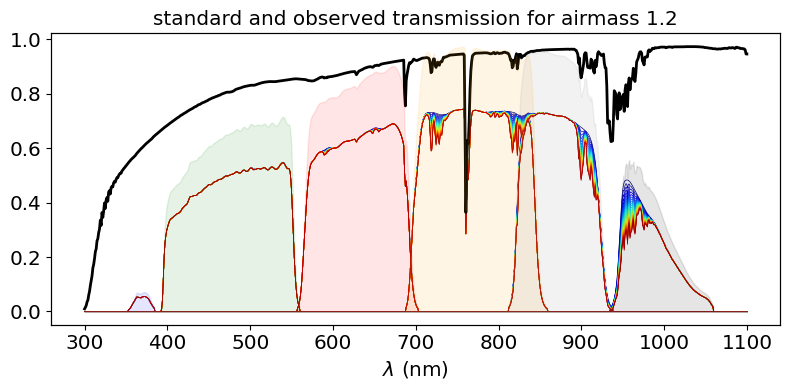

In [29]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(8,4))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):
  
    atm_bands = pc.coll_bandpass_total_nonstd[index]
  
    
    label = f"pwv={pwv:.1f}" 

    for f in filter_tagnames: 
        axs.plot(atm_bands[f].wavelen,atm_bands[f].sb,color=all_colors[index],label=label,lw=0.5)
  
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission for airmass 1.2")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()



In [30]:
#all_df_magcol = ComputeColors(pc,the_sed1,the_sed2)
#df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
#z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]

#dx = np.diff(df_diffcol.pwv.values).mean()
#dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
#dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)

In [31]:
df_mag_pkl = pd.DataFrame(columns = ["index","filename","spectype",
                                 "magu","magg","magr","magi","magz","magy",
                                 "aduu","adug","adur","adui","aduz","aduy"])
mags_std = {}
adcs_stdmag = {}

for index in np.arange(NSED):
    spectype = all_sed_type[index]
    filename = all_sed_filename[index]
    the_sed = all_sed[index] 
    for index2,f in enumerate(filter_tagnames) :
        mags_std[f] = the_sed.calc_mag(pc.bandpass_total_std[f])
        adcs_stdmag[f] = -2.5*np.log10(the_sed.calc_adu(pc.bandpass_total_std[f],photoparams))
    df_mag_pkl.loc[index] = [ index,filename, spectype ,
                    mags_std["u"],mags_std["g"],mags_std["r"],mags_std["i"],mags_std["z"],mags_std["y"],
                    adcs_stdmag["u"],adcs_stdmag["g"],adcs_stdmag["r"],adcs_stdmag["i"],adcs_stdmag["z"],adcs_stdmag["y"]]
                                
df_mag_pkl["magG_R"] = df_mag_pkl["magg"] - df_mag_pkl["magr"]
df_mag_pkl["magZ_Y"] = df_mag_pkl["magz"] - df_mag_pkl["magy"]
df_mag_pkl["aduG_R"] = df_mag_pkl["adug"] - df_mag_pkl["adur"]
df_mag_pkl["aduZ_Y"] = df_mag_pkl["aduz"] - df_mag_pkl["aduy"]


In [32]:
 df_mag_pkl

,index,filename,spectype,magu,magg,magr,magi,magz,magy,aduu,adug,adur,adui,aduz,aduy,magG_R,magZ_Y,aduG_R,aduZ_Y
0,0,pickles_uk_1.fits,O5V,18.959203,19.402100,20.0,20.400749,20.646363,20.848755,-5.246761,-8.989528,-8.168777,-7.849374,-7.029320,-5.651013,-0.597900,-0.202393,-0.820751,-1.378307
1,1,pickles_uk_2.fits,O9V,19.020089,19.402325,20.0,20.374430,20.635107,20.849812,-5.185875,-8.989303,-8.168777,-7.875693,-7.040576,-5.649957,-0.597675,-0.214705,-0.820526,-1.390619
2,2,pickles_uk_3.fits,B0V,19.141362,19.432507,20.0,20.364821,20.594126,20.781838,-5.064602,-8.959121,-8.168777,-7.885303,-7.081557,-5.717930,-0.567493,-0.187712,-0.790344,-1.363627
3,3,pickles_uk_4.fits,B1V,19.370967,19.529000,20.0,20.343297,20.514999,20.702119,-4.834997,-8.862627,-8.168777,-7.906827,-7.160684,-5.797650,-0.471000,-0.187120,-0.693850,-1.363035
4,4,pickles_uk_5.fits,B3V,19.660430,19.558667,20.0,20.271115,20.451436,20.630538,-4.545534,-8.832961,-8.168777,-7.979009,-7.224247,-5.869231,-0.441333,-0.179101,-0.664184,-1.355016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,121,pickles_uk_127.fits,G8I,23.288625,20.960168,20.0,19.795892,19.750549,19.676438,-0.917339,-7.431460,-8.168777,-8.454232,-7.925134,-6.823330,0.960168,0.074111,0.737317,-1.101804
122,122,pickles_uk_128.fits,K2I,24.177259,21.195534,20.0,19.651938,19.525665,19.355184,-0.028705,-7.196094,-8.168777,-8.598186,-8.150018,-7.144584,1.195534,0.170480,0.972683,-1.005434
123,123,pickles_uk_129.fits,K3I,24.377812,21.303918,20.0,19.587114,19.459740,19.275184,0.171848,-7.087710,-8.168777,-8.663010,-8.215943,-7.224584,1.303918,0.184556,1.081067,-0.991359
124,124,pickles_uk_130.fits,K4I,24.533828,21.387016,20.0,19.416923,19.127204,18.960023,0.327864,-7.004611,-8.168777,-8.833201,-8.548479,-7.539745,1.387016,0.167181,1.164166,-1.008734


/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_8770/1966446655.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(labels,rotation=0);


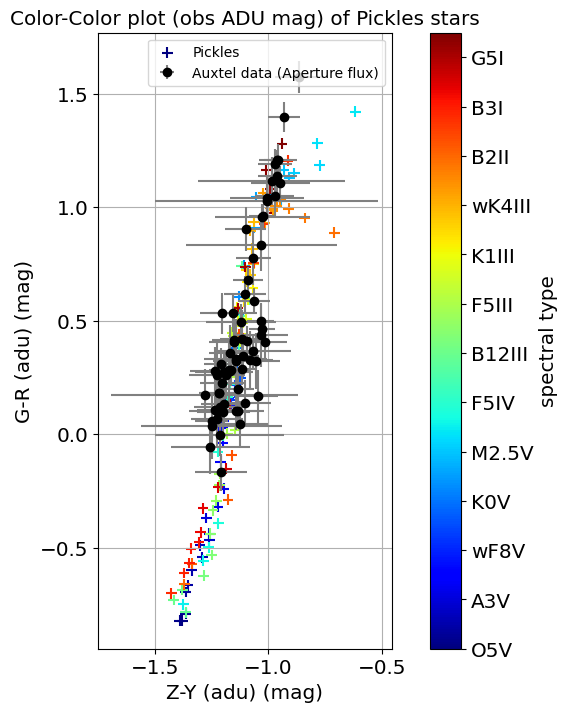

In [34]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

df_mag_pkl.plot.scatter(x="aduZ_Y",y="aduG_R",marker="+",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)

for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_mag_pkl.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (obs ADU mag) of Pickles stars")
ax.set_xlabel("Z-Y (adu) (mag)")
ax.set_ylabel("G-R (adu) (mag)")
ax.set_aspect("equal")
ax.errorbar(df_data["z_y_ap"],df_data["g_r_ap"],xerr=df_data["sig_z_y_ap"] , yerr=df_data["sig_g_r_ap"], fmt="o",color='k',ecolor="grey",label="Auxtel data (Aperture flux)")


ax.legend()


/var/folders/cq/vms8st5136z3q5xx4rd9xqfr0000gw/T/ipykernel_8770/2917068640.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(labels,rotation=0);


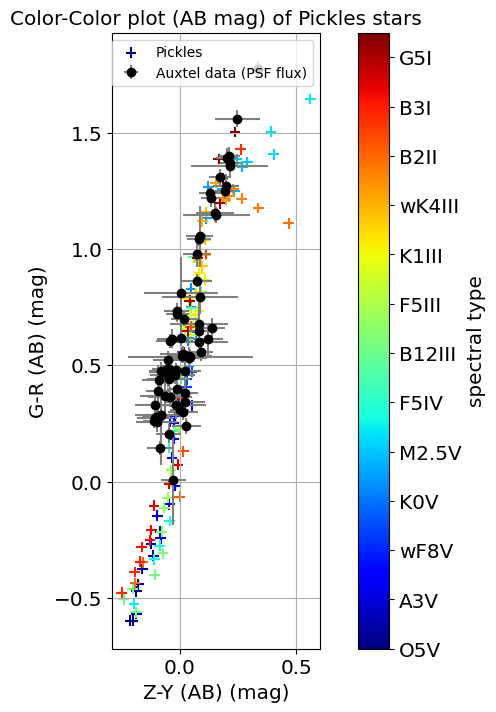

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

df_mag_pkl.plot.scatter(x="magZ_Y",y="magG_R",marker="+",c="index",s=60,colormap="jet",ax=ax,grid=True,colorbar=False,label="Pickles")
#cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
cbar = plt.colorbar(ax.collections[0],ax=ax)
cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)

for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_mag_pkl.loc[the_label,"spectype"]
cbar.ax.set_yticklabels(labels,rotation=0);
ax.set_title("Color-Color plot (AB mag) of Pickles stars")
ax.set_xlabel("Z-Y (AB) (mag)")
ax.set_ylabel("G-R (AB) (mag)")
ax.set_aspect("equal")
ax.errorbar(df_data["z_y_psf"],df_data["g_r_psf"],xerr=df_data["sig_z_y_psf"] , yerr=df_data["sig_g_r_psf"], fmt="o",color='k',ecolor="grey",label="Auxtel data (PSF flux)")

ax.legend()
